# NFT Authenticity and Prediction using Sentiment Analysis and Deep Learning

## Imports

In [ ]:
import os
import json
import asyncio
import tqdm
import tqdm.asyncio
import nest_asyncio
import tweepy
import time
import calendar
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import svm, metrics, preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from dotenv import load_dotenv
from pprint import pprint
from datetime import datetime
from dateutil.relativedelta import relativedelta
from aiohttp import ClientSession, TCPConnector
from matplotlib import pyplot
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nest_asyncio.apply()
load_dotenv()

## Data Collection

Get Project List Data

In [ ]:
df = pd.read_csv("collections_2.csv")
sample_slugs = df['slug'].values
slug_date = {}
slug_price = {}

### OpenSea Metrics from Collection Slugs

Asynchronous Data Collection

In [ ]:
async def fetchData(url,session):
    '''
    This the main task function which takes a URL and an Async Session
    and fetches the data from the URL. Since we knew the format of a valid
    response, we check if the response was valid and if it isn't, then we 
    try the request again in another 5 seconds until we get a valid response
    '''
    async with session.get(url) as response:
        try:
            response = await response.read()
            assert 'detail' not in json.loads(response.decode('UTF-8'))
            return response
        except:
            await asyncio.sleep(5)
            return await fetchData(url,session)

async def transactionScrape():
    '''
    API KEY REQUIRED
    ---------------------
    Utilizes asyncio and aiohttp to make asynchronous requests utilizing the delegated
    task function seen above. In this particular use case, we take the creation dates for
    projects obtained from the collection scrape function below and increment daily while 
    fetching transaction data for that time period. As a result, we get 2 weeks worth of 
    transactions that begin when the project is made public. We parse these transactions to
    get the total volume of ETH traded and the number of transaction made.
    '''
    tasks = []
    responses = []
    connector = TCPConnector(limit_per_host=1)
    url = "https://api.opensea.io/api/v1/events?collection_slug={slug}&only_opensea=false&event_type=successful&limit=300&occurred_after={start}&occurred_before={end}"
    headers={"Accept": "application/json", "X-API-KEY": os.getenv('OPENSEA_API_KEY')}
    async with ClientSession(connector=connector, headers=headers) as session:
        for i in range(len(sample_slugs)):
            start_date = datetime.fromisoformat(slug_date[sample_slugs[i]].split('T')[0]) - relativedelta(days=1)
            for j in range(14):
                start_date = start_date + relativedelta(days=1)
                end_date = start_date + relativedelta(days=1) 
                task = asyncio.ensure_future(fetchData(url.format(slug=sample_slugs[i],start=start_date.timestamp(), end=end_date.timestamp()),session))
                tasks.append(task)
        for f in tqdm.tqdm(asyncio.as_completed(tasks), total=len(tasks)):
            responses.append(await f)
    for response in responses:
        response = json.loads(response.decode('utf8'))
        try:
            collection_slug = response['asset_events'][0]['collection_slug'] 
            for event in response['asset_events']:
                slug_price[collection_slug]['total_volume'] += float(event['total_price'])/1000000000000000000
                slug_price[collection_slug]['num_transactions'] += 1
        except:
            pass

async def collectionScrape():
    '''
    Utilizes asyncio and aiohttp to make asynchronous requests utilizing the delegated
    task function seen above. In this particular use case, we are simply getting collection
    information from OpenSea with the primary goal of getting the creation_date to be used 
    in transaction scraping. This API endpoint is public so no API key is required for this.
    '''
    tasks = []
    responses = []
    connector = TCPConnector()
    url = "https://api.opensea.io/api/v1/collection/{}"
    async with ClientSession(connector=connector) as session:
        for i in range(len(sample_slugs)):
            task = asyncio.ensure_future(fetchData(url.format(sample_slugs[i]),session))
            tasks.append(task)
        for f in tqdm.tqdm(asyncio.as_completed(tasks), total=len(tasks)):
            responses.append(await f)
    for response in responses:
        response = json.loads(response.decode('utf8'))
        collection = response['collection']
        name = collection['name']
        floor = collection['stats']['floor_price']
        volume = collection['stats']['total_volume']
        date_created = collection['created_date']
        slug_date[collection['slug']] = date_created
        slug_price[collection['slug']] = {'total_volume' : 0, 'num_transactions': 0 }
        print(f'{name}: Floor: {floor}ETH --- Total Volume: {volume}ETH --- Created {date_created}')


Run Collection Script - outputs to slug_date dictionary 

In [ ]:
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(collectionScrape())
loop.run_until_complete(future)

Run Transaction Collections - outputs to slug_price dictionary

In [ ]:
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(transactionScrape())
loop.run_until_complete(future)

Feature Extraction and Writing to Features File

In [ ]:
df['volume'] = df['slug'].apply(lambda x: slug_price[x]['total_volume'])
df['transaction_count'] = df['slug'].apply(lambda x: slug_price[x]['num_transactions'])
df['average_sale'] = df['slug'].apply(lambda x: slug_price[x]['total_volume'] / slug_price[x]['num_transactions'])
df.to_csv('features.csv', mode='a', index=True, header=False)

### Twitter Historical Tweet Collection

Get Authorization Credentials

In [ ]:
consumer_key = os.getenv('CONSUMER_KEY')
consumer_secret = os.getenv('CONSUMER_SECRET')
access_token = os.getenv('ACCESS_TOKEN')
access_token_secret = os.getenv('ACCESS_TOKEN_SECRET')

Configure Tweepy

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

Read in the Projects List

In [ ]:
collections = pd.read_csv("collections.csv")["name"]
pprint(collections)

Tweet Collection Script

In [1]:
def get_tweets(proj):
    filename = "./data/" + "_".join(proj.split(" ")) + ".csv"
    print("Collecting tweets for:", proj)
    print("Writing results to", filename)
    resp = api.search_full_archive("prod", proj)
    tweets = []
    timestamps = []
    for status in resp:
        tweets.append(status.text)
        timestamps.append(status.created_at)
    df = pd.DataFrame({
            "tweets": pd.Series(tweets),
            "timestamps": pd.Series(timestamps)
            })
    df.to_csv(filename)

Run Tweet Collection Script

In [ ]:
for proj in collections:
    get_tweets(proj)

## Use sentiment analysis to encode tweets

In [200]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

In [201]:
def get_sentiment(tweets):
    '''
    Uses a VADER model to return the avg sentiment for a collection of tweets
    '''
    analyzer = SentimentIntensityAnalyzer()
    all_scores = [0, 0, 0]
    for tweet in tweets:
        score = analyzer.polarity_scores(tweet)
        all_scores.append(np.array([score['neg'], score['neu'], score['pos']]))
    return np.array(all_scores).mean(axis=0)

In [ ]:
def get_volume_metric(timestamps):
    '''
    Function to compute the standard deviation of a series of timestamps
    this is meant to act as a metric for volume
    in practice this is an imperfect metric because it is heavily reliant upon twitter's api. 
    we were not able to get a premium license so our data was limited
    '''
    distances = []
    for t in timestamps:
        # get the number of seconds since the epoch
        distances.append(calendar.timegm(time.strptime(t, "%Y-%m-%d %H:%M:%S+00:00")))
    return pd.Series(distances).std()

### Add sentiment encodings to feature dataframe

In [ ]:
features = pd.read_csv("features.csv")
negative_scores = []
neutral_scores = []
positive_scores = []
volume = []

for proj in features["name"]:
    filename = "./data/" + "_".join(proj.split(" ")) + ".csv"
    tweet_data = pd.read_csv(filename)
    print("Analyzing tweets for", proj)
    scores = get_sentiment(tweet_data["tweets"])
    timestamp_deviation = get_volume_metric(tweet_data["timestamps"])
    try:
        negative_scores.append(scores[0])
        neutral_scores.append(scores[1])
        positive_scores.append(scores[2])
    except Exception:
        negative_scores.append(0)
        neutral_scores.append(0)
        positive_scores.append(0)
    if timestamp_deviation:
        volume.append(timestamp_deviation)
    else:
        volume.append(0)
        
features["negative_score"] = pd.Series(negative_scores)
features["neutral_score"] = pd.Series(neutral_scores)
features["positive_score"] = pd.Series(positive_scores)
features["tweet_volume"] = pd.Series(volume)

features.to_csv("features.csv")

In [ ]:
features.head()

## Classification Models

### Gaussian Naive Bayes

In [226]:
def predictNB(x_train, x_test, y_train, y_test):
    gnb = GaussianNB()
    y_pred = gnb.fit(x_train, y_train).predict(x_test)
    return metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred), metrics.f1_score(y_test, y_pred)

### Support Vector Machine (SVM)

In [225]:
def predictSVM(x_train, x_test, y_train, y_test):
    model = svm.SVC()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    return metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred), metrics.f1_score(y_test, y_pred)

### Multilayer Perceptron (MLP)

In [257]:
def predictMLP(x_train, x_test, y_train, y_test):
    n_features = x_train.shape[1]
    model = Sequential()
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Precision'])
    history = model.fit(x_train, y_train, epochs=1000, batch_size=8, verbose=0)
    pyplot.title('Learning Curve')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Binary Cross Entropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()   
    loss, acc, precision = model.evaluate(x_test, y_test, verbose=0)
    
    # get f1 score
    y_pred = []
    for i in model.predict(x_test):
        if i >= 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    
    return acc, precision, metrics.f1_score(y_test, y_pred)


## Data Preprocessing

We will create different training sets using text features only, price features only, and a combination of price and text features.

### Extract Features and Labels

In [ ]:
dataset = pd.read_csv("features.csv").fillna(0)

x_data_price = dataset[['transaction_count', 'volume', 'average_sale']]
x_data_text = dataset[['negative_score','neutral_score','positive_score','tweet_volume']]
x_data_combined = dataset[['transaction_count', 'volume', 'average_sale','negative_score','neutral_score','positive_score','tweet_volume']]

y_data = dataset['label']

### Split Data into Testing and Training

In [ ]:
x_train_price, x_test_price, y_train_price, y_test_price = train_test_split(x_data_price, y_data ,test_size = 0.2)

x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(x_data_text, y_data ,test_size = 0.2)

x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(x_data_combined, y_data ,test_size = 0.2)

### Standardize The Features

In [ ]:
scaler = preprocessing.StandardScaler().fit(x_train_price)
x_train_scaled_price = scaler.transform(x_train_price)

scaler = preprocessing.StandardScaler().fit(x_test_price)
x_test_scaled_price = scaler.transform(x_test_price)

scaler = preprocessing.StandardScaler().fit(x_train_text)
x_train_scaled_text = scaler.transform(x_train_text)

scaler = preprocessing.StandardScaler().fit(x_test_text)
x_test_scaled_text = scaler.transform(x_test_text)

scaler = preprocessing.StandardScaler().fit(x_train_combined)
x_train_scaled_combined = scaler.transform(x_train_combined)

scaler = preprocessing.StandardScaler().fit(x_test_combined)
x_test_scaled_combined = scaler.transform(x_test_combined)

### Preview the data

In [ ]:
x_train_combined.head()

In [ ]:
x_train_text.describe()

## Running the Models

All models output a tuple with the following definition: (accuracy, precision, F1 score)

## Text Data Only

### Naive Bayes Prediction

In [258]:
predictNB(x_train_scaled_text, x_test_scaled_text, y_train_text, y_test_text)

(1.0, 1.0, 1.0)

### SVM Model Prediction

In [259]:
predictSVM(x_train_scaled_text, x_test_scaled_text, y_train_text, y_test_text)

(0.75, 0.75, 0.75)

### MLP Model Prediction

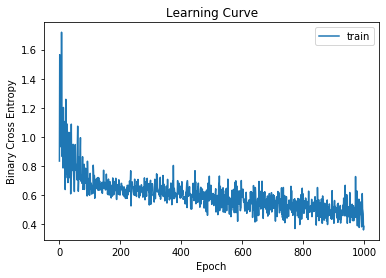

(0.875, 1.0, 0.8571428571428571)

In [260]:
predictMLP(x_train_scaled_text, x_test_scaled_text, y_train_text, y_test_text)

## Price Data Only

### Naive Bayes Prediction

In [261]:
predictNB(x_train_scaled_price, x_test_scaled_price, y_train_price, y_test_price)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.625, 0.0, 0.0)

### SVM Model Prediction

In [262]:
predictSVM(x_train_scaled_price, x_test_scaled_price, y_train_price, y_test_price)

(1.0, 1.0, 1.0)

### MLP Model Prediction

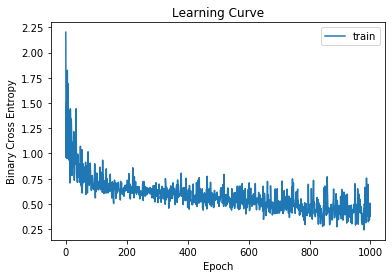

(1.0, 1.0, 1.0)

In [263]:
predictMLP(x_train_scaled_price, x_test_scaled_price, y_train_price, y_test_price)

## Price and Text Data

### Naive Bayes Prediction

In [264]:
predictNB(x_train_scaled_combined, x_test_scaled_combined, y_train_combined, y_test_combined)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.75, 0.0, 0.0)

### SVM Model Prediction

In [265]:
predictSVM(x_train_scaled_combined, x_test_scaled_combined, y_train_combined, y_test_combined)

(0.875, 0.6666666666666666, 0.8)

### MLP Model Prediction

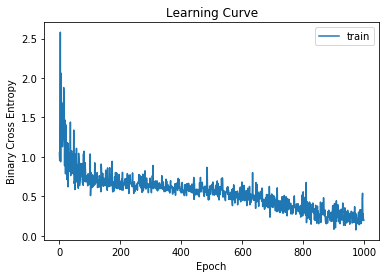

(0.75, 0.5, 0.6666666666666666)

In [266]:
predictMLP(x_train_scaled_combined, x_test_scaled_combined, y_train_combined, y_test_combined)